# Training a Single Agent with RL

This notebook demonstrates how to use the `SingleAgentWrapper` to train a single agent while other agents are controlled by fixed policies.

## Overview

The `SingleAgentWrapper` simplifies single-agent RL training:
- **Focus on one agent**: Specify which agent to train
- **Auto-control others**: Other agents follow fixed policies
- **Standard RL interface**: Returns `(obs, reward, done, info)` for the focused agent
- **Batched execution**: Supports `batch_size > 1` for parallel training

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

def to_numpy(x):
    """Convert torch tensor or numpy array to numpy array."""
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

In [2]:

from envs.word_batch_env import WordBatchEnv
from envs.wrappers import SingleAgentWrapper
from agents.spymaster import RandomSpymaster, SpymasterParams
from agents.guesser import RandomGuesser, GuesserParams

## 1. Creating a SingleAgentWrapper

Let's focus on training the red guesser while other agents use fixed policies.

In [3]:
# Create base environment
base_env = WordBatchEnv(batch_size=4, seed=42)

# Create fixed policies for other agents
red_spy = RandomSpymaster(team="red")
blue_spy = RandomSpymaster(team="blue")
blue_guess = RandomGuesser(team="blue")

policy_map = {
    "red_spy": lambda obs: red_spy.get_clue(obs),
    "blue_spy": lambda obs: blue_spy.get_clue(obs),
    "blue_guess": lambda obs: blue_guess.get_guess(obs),
}

# Wrap environment to focus on red_guess
env = SingleAgentWrapper(
    env=base_env,
    agent_id="red_guess",
    policy_map=policy_map
)

print(f"Focused agent: {env.agent_id}")
print(f"Batch size: {env.batch_size}")

Focused agent: red_guess
Batch size: 4


## 2. Basic Interaction Loop

The wrapper provides a standard RL interface for the focused agent.

In [4]:
# Reset environment
obs = env.reset(seed=42)

print("Observation keys:", obs.keys())
print(f"Words: {len(obs['words'])} games, {len(obs['words'][0])} words each")  # List of lists
print(f"Revealed shape: {obs['revealed'].shape}")  # (4, 25)
print(f"Current clue: {obs['current_clue']}")  # List of 4 clues

# Take a step with red_guess action only
action = {"tile_index": np.array([0, 1, 2, 3])}  # Batched action for 4 games
obs, reward, done, info = env.step(action)

print(f"\nReward shape: {reward.shape}")  # (4,)
print(f"Done shape: {done.shape}")  # (4,)
print(f"Rewards: {reward}")

Observation keys: dict_keys(['words', 'revealed', 'current_team', 'phase', 'colors', 'current_clue', 'current_clue_number', 'remaining_guesses', 'role_encoding'])
Words: 4 games, 25 words each
Revealed shape: torch.Size([4, 25])
Current clue: ['', '', '', '']

Reward shape: torch.Size([4])
Done shape: torch.Size([4])
Rewards: tensor([0., 0., 0., 0.], device='mps:0')


## 3. Simple Random Policy Baseline

Let's collect data with a random policy to establish a baseline.

In [5]:
def collect_episodes(env, n_episodes, seed=42):
    """Collect episodes with random policy."""
    episode_rewards = []
    episode_lengths = []
    
    episodes_collected = 0
    
    while episodes_collected < n_episodes:
        obs = env.reset(seed=seed + episodes_collected)
        batch_rewards = np.zeros(env.batch_size)
        batch_lengths = np.zeros(env.batch_size, dtype=int)
        batch_done = np.zeros(env.batch_size, dtype=bool)
        
        for step in range(100):  # Max steps per episode
            # Random action
            action = {"tile_index": np.random.randint(0, 25, size=env.batch_size)}
            obs, reward, done, info = env.step(action)
            
            # Convert torch tensors to numpy
            reward = to_numpy(reward)
            done = to_numpy(done)
            
            # Accumulate rewards and lengths for non-done episodes
            batch_rewards += reward * (~batch_done)
            batch_lengths += (~batch_done).astype(int)
            batch_done |= done
            
            if np.all(batch_done):
                break
        
        # Store completed episodes
        for i in range(env.batch_size):
            if episodes_collected < n_episodes:
                episode_rewards.append(batch_rewards[i])
                episode_lengths.append(batch_lengths[i])
                episodes_collected += 1
    
    return episode_rewards[:n_episodes], episode_lengths[:n_episodes]

# Collect baseline data
print("Collecting random policy baseline...")
rewards, lengths = collect_episodes(env, n_episodes=100, seed=42)

print(f"\nRandom Policy Baseline:")
print(f"  Average reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
print(f"  Average length: {np.mean(lengths):.1f} ± {np.std(lengths):.1f}")
print(f"  Min/Max reward: {np.min(rewards):.2f} / {np.max(rewards):.2f}")


Random Policy Baseline:
  Average reward: -9.15 ± 10.58
  Average length: 22.6 ± 14.8
  Min/Max reward: -23.00 / 14.00


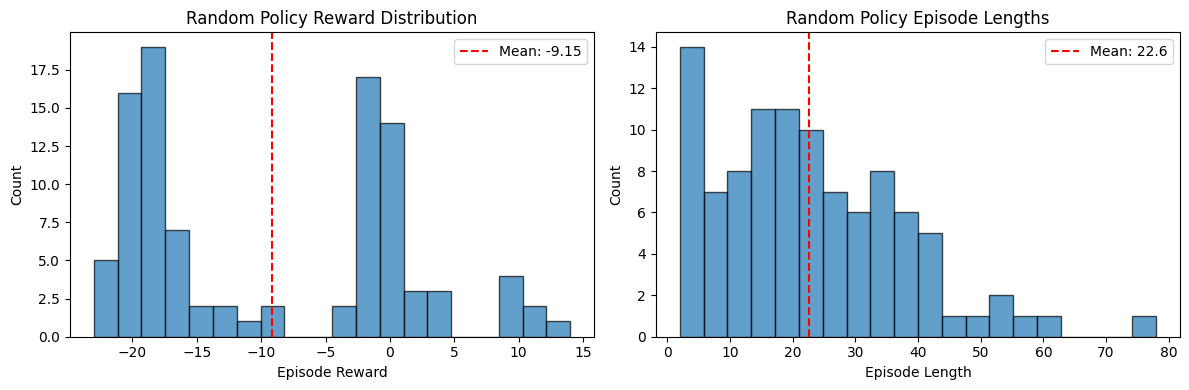

In [7]:
# Plot reward distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(rewards, bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(rewards), color='red', linestyle='--', label=f'Mean: {np.mean(rewards):.2f}')
axes[0].set_xlabel('Episode Reward')
axes[0].set_ylabel('Count')
axes[0].set_title('Random Policy Reward Distribution')
axes[0].legend()

axes[1].hist(lengths, bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(lengths), color='red', linestyle='--', label=f'Mean: {np.mean(lengths):.1f}')
axes[1].set_xlabel('Episode Length')
axes[1].set_ylabel('Count')
axes[1].set_title('Random Policy Episode Lengths')
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Simple Heuristic Policy

Let's implement a simple heuristic that prioritizes unrevealed tiles.

In [8]:
def heuristic_policy(obs):
    """
    Simple heuristic: Pick a random unrevealed tile.
    This is slightly better than pure random.
    """
    # Convert revealed to numpy if it's a torch tensor
    revealed = to_numpy(obs['revealed'])
    batch_size = revealed.shape[0]
    actions = np.zeros(batch_size, dtype=np.int32)
    
    for b in range(batch_size):
        # Find unrevealed tiles
        unrevealed = np.where(revealed[b] == 0)[0]
        
        if len(unrevealed) > 0:
            actions[b] = np.random.choice(unrevealed)
        else:
            # Fallback to random
            actions[b] = np.random.randint(0, 25)
    
    return {"tile_index": actions}

# Test heuristic policy
def collect_episodes_with_policy(env, policy_fn, n_episodes, seed=42):
    """Collect episodes with given policy."""
    episode_rewards = []
    episode_lengths = []
    
    episodes_collected = 0
    
    while episodes_collected < n_episodes:
        obs = env.reset(seed=seed + episodes_collected)
        batch_rewards = np.zeros(env.batch_size)
        batch_lengths = np.zeros(env.batch_size, dtype=int)
        batch_done = np.zeros(env.batch_size, dtype=bool)
        
        for step in range(100):
            action = policy_fn(obs)
            obs, reward, done, info = env.step(action)
            
            # Convert torch tensors to numpy
            reward = to_numpy(reward)
            done = to_numpy(done)
            
            batch_rewards += reward * (~batch_done)
            batch_lengths += (~batch_done).astype(int)
            batch_done |= done
            
            if np.all(batch_done):
                break
        
        for i in range(env.batch_size):
            if episodes_collected < n_episodes:
                episode_rewards.append(batch_rewards[i])
                episode_lengths.append(batch_lengths[i])
                episodes_collected += 1
    
    return episode_rewards[:n_episodes], episode_lengths[:n_episodes]

print("Collecting heuristic policy data...")
heuristic_rewards, heuristic_lengths = collect_episodes_with_policy(
    env, heuristic_policy, n_episodes=100, seed=42
)

print(f"\nHeuristic Policy:")
print(f"  Average reward: {np.mean(heuristic_rewards):.2f} ± {np.std(heuristic_rewards):.2f}")
print(f"  Average length: {np.mean(heuristic_lengths):.1f} ± {np.std(heuristic_lengths):.1f}")

print(f"\nImprovement over random:")
print(f"  Reward delta: {np.mean(heuristic_rewards) - np.mean(rewards):.2f}")


Heuristic Policy:
  Average reward: -11.54 ± 10.69
  Average length: 18.5 ± 10.6

Improvement over random:
  Reward delta: -2.39


## 5. Observation Processing

For RL training, you typically need to process observations into features.

In [9]:
def extract_features(obs):
    """
    Extract simple features from observation.
    
    Returns:
        features: Shape (batch_size, n_features)
    """
    # Convert torch tensors to numpy
    revealed = to_numpy(obs['revealed']).astype(np.float32)  # (B, 25)
    clue_numbers = to_numpy(obs['current_clue_number']).astype(np.float32)
    
    batch_size = revealed.shape[0]
    clue_numbers = clue_numbers.reshape(batch_size, 1)  # (B, 1)
    
    features = np.concatenate([revealed, clue_numbers], axis=1)  # (B, 26)
    
    return features

# Test feature extraction
obs = env.reset(seed=42)
features = extract_features(obs)

print(f"Feature shape: {features.shape}")  # (4, 26)
print(f"Sample features (first game): {features[0][:5]}...")  # First 5 features

Feature shape: (4, 26)
Sample features (first game): [0. 0. 0. 0. 0.]...


## 6. Training with Different Opponents

You can train against different opponent policies by changing the policy_map.

In [11]:
# Try training against embedding agents (if available)
try:
    from agents.spymaster import EmbeddingSpymaster
    from agents.guesser import EmbeddingGuesser
    
    # Create stronger opponents
    red_spy_emb = EmbeddingSpymaster(team="red", params=SpymasterParams(n_candidate_clues=20, seed=42))
    blue_spy_emb = EmbeddingSpymaster(team="blue", params=SpymasterParams(n_candidate_clues=20, seed=43))
    blue_guess_emb = EmbeddingGuesser(team="blue", params=GuesserParams(similarity_threshold=0.1, seed=44))
    
    embedding_policy_map = {
        "red_spy": lambda obs: red_spy_emb.get_clue(obs),
        "blue_spy": lambda obs: blue_spy_emb.get_clue(obs),
        "blue_guess": lambda obs: blue_guess_emb.get_guess(obs),
    }
    
    # Create new wrapped environment with stronger opponents
    base_env_hard = WordBatchEnv(batch_size=4, seed=42)
    env_hard = SingleAgentWrapper(
        env=base_env_hard,
        agent_id="red_guess",
        policy_map=embedding_policy_map
    )
    
    print("Testing against embedding opponents...")
    hard_rewards, hard_lengths = collect_episodes_with_policy(
        env_hard, heuristic_policy, n_episodes=50, seed=100
    )
    
    print(f"\nHeuristic vs Embedding Opponents:")
    print(f"  Average reward: {np.mean(hard_rewards):.2f} ± {np.std(hard_rewards):.2f}")
    print(f"  Average length: {np.mean(hard_lengths):.1f} ± {np.std(hard_lengths):.1f}")
    
except RuntimeError as e:
    print(f"Embedding agents unavailable: {e}")
    print("Install sentence-transformers to test against stronger opponents")

Testing against embedding opponents...

Heuristic vs Embedding Opponents:
  Average reward: -8.96 ± 11.39
  Average length: 18.9 ± 9.9


## 7. Integration with RL Libraries

The `SingleAgentWrapper` is compatible with popular RL libraries like Stable-Baselines3, RLlib, etc.

Here's a conceptual example (requires installing stable-baselines3):

```python
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Create environment
def make_wrapped_env(seed):
    base_env = WordBatchEnv(batch_size=1, seed=seed)
    return SingleAgentWrapper(
        env=base_env,
        agent_id="red_guess",
        policy_map=policy_map
    )

# Vectorize for SB3
vec_env = DummyVecEnv([lambda: make_wrapped_env(i) for i in range(4)])

# Train with PPO
model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100000)
```

## 8. Curriculum Learning

You can implement curriculum learning by gradually increasing opponent difficulty.

In [10]:
def evaluate_against_opponent(opponent_policy_map, n_episodes=50):
    """Evaluate heuristic policy against given opponents."""
    base_env = WordBatchEnv(batch_size=4, seed=42)
    wrapped_env = SingleAgentWrapper(
        env=base_env,
        agent_id="red_guess",
        policy_map=opponent_policy_map
    )
    
    rewards, lengths = collect_episodes_with_policy(
        wrapped_env, heuristic_policy, n_episodes=n_episodes, seed=42
    )
    
    return np.mean(rewards), np.mean(lengths)

# Curriculum: Random -> Seeded Random (more consistent) -> Embedding (if available)
curriculum_results = []

# Stage 1: Random opponents
print("Stage 1: Random opponents")
reward, length = evaluate_against_opponent(policy_map, n_episodes=30)
curriculum_results.append(('Random', reward, length))
print(f"  Avg reward: {reward:.2f}, Avg length: {length:.1f}")

# Stage 2: Seeded random (more deterministic)
print("\nStage 2: Seeded random opponents")
seeded_policy_map = {
    "red_spy": lambda obs: RandomSpymaster(team="red", params=SpymasterParams(seed=100)).get_clue(obs),
    "blue_spy": lambda obs: RandomSpymaster(team="blue", params=SpymasterParams(seed=101)).get_clue(obs),
    "blue_guess": lambda obs: RandomGuesser(team="blue", params=GuesserParams(seed=102)).get_guess(obs),
}
reward, length = evaluate_against_opponent(seeded_policy_map, n_episodes=30)
curriculum_results.append(('Seeded Random', reward, length))
print(f"  Avg reward: {reward:.2f}, Avg length: {length:.1f}")

# Print curriculum summary
print("\n=== Curriculum Results ===")
for stage, reward, length in curriculum_results:
    print(f"{stage:20s} - Reward: {reward:6.2f}, Length: {length:5.1f}")

Stage 1: Random opponents
  Avg reward: -5.90, Avg length: 18.6

Stage 2: Seeded random opponents
  Avg reward: -7.60, Avg length: 21.4

=== Curriculum Results ===
Random               - Reward:  -5.90, Length:  18.6
Seeded Random        - Reward:  -7.60, Length:  21.4


## Summary

You now know how to:
- Use `SingleAgentWrapper` to focus on training one agent
- Collect episode data with different policies
- Extract features from observations for RL
- Train against different opponent difficulties
- Implement curriculum learning strategies
- Prepare for integration with RL libraries

Next notebook:
- **04_parameter_sweeps.ipynb**: Systematically optimize agent parameters